In [3]:
import pandas as pd 
import numpy as np
import openpyxl
import yfinance as yf
from datetime import datetime, timedelta

# Here I will put all of the external data I used in the model:

## 1 . CPI,PPI,NONFARM,FOMC

In [153]:
import pandas as pd
# Load the Excel file with multiple sheets into a dictionary of DataFrames

sheets_dict = pd.read_excel('act vs forecast.xlsx', sheet_name=None)

# Extract each sheet into separate DataFrames
df1 = sheets_dict[list(sheets_dict.keys())[0]]
df2 = sheets_dict[list(sheets_dict.keys())[1]]
df3 = sheets_dict[list(sheets_dict.keys())[2]]
df4 = sheets_dict[list(sheets_dict.keys())[3]]
df5 = sheets_dict[list(sheets_dict.keys())[4]]
df6 = sheets_dict[list(sheets_dict.keys())[5]]
df7 = sheets_dict[list(sheets_dict.keys())[6]]

# Optional: print sheet names to verify
print("Sheet names:", list(sheets_dict.keys()))

Sheet names: ['GDP', 'nonfarm', 'CPI', 'PPI', 'unemployment rate', 'core_PCE', 'FOMC']


In [154]:
# arrange the dates
for df in [df1, df2, df3, df4, df5,df6,df7]:
    #df = df.drop('Time', axis=1)
    df['Release Date'] = df['Release Date'].str.replace(r"\s*\(.*\)", "", regex=True)  # remove (anything)
    df['Release Date'] = pd.to_datetime(df['Release Date'], format='%b %d, %Y')
    df['Release Date'] = df['Release Date'].dt.date

df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Release Date       126 non-null    object 
 1   Time               126 non-null    object 
 2   Actual_core_PCE    125 non-null    float64
 3   Forecast_core_PCE  119 non-null    float64
 4   Previous_core_PCE  126 non-null    float64
dtypes: float64(3), object(2)
memory usage: 5.0+ KB


In [155]:
#move the time column
df1.drop('Time', axis=1, inplace=True)
df2.drop('Time', axis=1, inplace=True)
df3.drop('Time', axis=1, inplace=True)
df4.drop('Time', axis=1, inplace=True)
df5.drop('Time', axis=1, inplace=True)
df6.drop('Time', axis=1, inplace=True)
df7.drop('Time', axis=1, inplace=True)


In [156]:
# when using a loop it does not work
# Convert 'Release Date' to datetime format for each DataFrame
df1['Release Date'] = pd.to_datetime(df1['Release Date'])
df2['Release Date'] = pd.to_datetime(df2['Release Date'])
df3['Release Date'] = pd.to_datetime(df3['Release Date'])
df4['Release Date'] = pd.to_datetime(df4['Release Date'])
df5['Release Date'] = pd.to_datetime(df5['Release Date'])
df6['Release Date'] = pd.to_datetime(df6['Release Date'])
df7['Release Date'] = pd.to_datetime(df7['Release Date'])
df7.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Release Date   145 non-null    datetime64[ns]
 1   Actual_FOMC    139 non-null    float64       
 2   Forecast_FOMC  135 non-null    float64       
 3   Previous_FOMC  140 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 4.7 KB


In [157]:
for df in [df1, df2, df3, df4, df5,df6,df7]:
    df.rename(columns={'Release Date': 'ds'}, inplace=True)

df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ds             145 non-null    datetime64[ns]
 1   Actual_FOMC    139 non-null    float64       
 2   Forecast_FOMC  135 non-null    float64       
 3   Previous_FOMC  140 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 4.7 KB


### Merge the data

In [158]:

from functools import reduce

# Suppose your seven DataFrames are:
# df1, df2, df3, df4, df5, df6, df7
dfs = [df1, df2, df3, df4, df5, df6, df7]

# Merge all of them on “ds” using an outer join
merged_df = reduce(
    lambda left, right: pd.merge(left, right, on="ds", how="outer"),
    dfs
)
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          973 non-null    datetime64[ns]
 1   Actual_GDP                  204 non-null    float64       
 2   Forecast_GDP                204 non-null    float64       
 3   Previous_GDP                205 non-null    float64       
 4   Actual_nonfarm              206 non-null    object        
 5   Forecast_nonfarm            206 non-null    object        
 6   Previous_nonfarm            206 non-null    object        
 7   Actual_CPI                  155 non-null    float64       
 8   Forecast_CPI                156 non-null    float64       
 9   Previous_CPI                156 non-null    float64       
 10  Actual_PPI                  170 non-null    float64       
 11  Forecast_PPI                156 non-null    float64       

In [147]:
merged_df['Actual_nonfarm'].head(20)

0       NaN
1      -63K
2       NaN
3       NaN
4      -80K
5       NaN
6      -20K
7      -49K
8       NaN
9       NaN
10     -62K
11      NaN
12     -51K
13      NaN
14      NaN
15     -84K
16      NaN
17      NaN
18    -159K
19      NaN
Name: Actual_nonfarm, dtype: object

In [148]:
merged_df.describe()

ds  Actual_GDP  Forecast_GDP  Previous_GDP  \
count                            973  204.000000    204.000000    205.000000   
mean   2017-10-14 21:00:55.498458368    0.020015      0.019814      0.019654   
min              2008-02-28 00:00:00   -0.329000     -0.341000     -0.329000   
25%              2014-02-20 00:00:00    0.013000      0.012750      0.012000   
50%              2018-01-12 00:00:00    0.023000      0.024000      0.022000   
75%              2021-10-01 00:00:00    0.031250      0.030000      0.032000   
max              2025-12-10 00:00:00    0.334000      0.332000      0.334000   
std                              NaN    0.060655      0.060460      0.060593   

       Actual_CPI  Forecast_CPI  Previous_CPI  Actual_PPI  Forecast_PPI  \
count  155.000000    156.000000    156.000000  170.000000    156.000000   
mean     0.026161      0.026026      0.026160    0.025388      0.024231   
min     -0.002000     -0.001000     -0.002000   -0.016000     -0.014000   
25%      0.014500      0.015000      0.014750    0.009000      0.008000   
50%      0.020000      0.020000      0.020000    0.020000      0.018000   
75%      0.030000      0.030000      0.030000    0.030750      0.027250   
max      0.091000      0.088000      0.091000    0.113000      0.109000   
std      0.020843      0.020460      0.020779    0.027706      0.028102   

       Previous_PPI  Actual_unemployment rate  Forecast_unemployment rate  \
count    171.000000                201.000000                  201.000000   
mean       0.025585                  0.060055                    0.060886   
min       -0.016000                  0.034000                    0.034000   
25%        0.009000                  0.040000                    0.039000   
50%        0.020000                  0.053000                    0.053000   
75%        0.030500                  0.079000                    0.079000   
max        0.115000                  0.147000                    0.197000   
std        0.027861                  0.022982                    0.025088   

       Previous_unemployment rate  Actual_core_PCE  Forecast_core_PCE  \
count                  201.000000       125.000000         119.000000   
mean                     0.060124         0.024096           0.024496   
min                      0.034000         0.009000           0.009000   
25%                      0.040000         0.015000           0.015000   
50%                      0.053000         0.017000           0.018000   
75%                      0.079000         0.031000           0.033500   
max                      0.147000         0.054000           0.055000   
std                      0.022964         0.012617           0.012735   

       Previous_core_PCE  Actual_FOMC  Forecast_FOMC  Previous_FOMC  
count         126.000000   139.000000     135.000000     140.000000  
mean            0.024151     0.013813       0.013889       0.013929  
min             0.010000     0.002500       0.002500       0.002500  
25%             0.015000     0.002500       0.002500       0.002500  
50%             0.018000     0.002500       0.002500       0.002500  
75%             0.030500     0.020000       0.020000       0.020000  
max             0.053000     0.055000       0.055000       0.055000  
std             0.012627     0.016927       0.017179       0.016922

In [159]:
def clean_value(val):
    if val == 'none event' or pd.isna(val):
        return np.nan
    #try:
    val = str(val).replace(',', '')
    val = str(val).replace('K', '')  # Remove 'k'
    return float(val)

merged_df['Actual_nonfarm'] = merged_df['Actual_nonfarm'].apply(clean_value)
merged_df['Actual_nonfarm'].head(20)

0       NaN
1     -63.0
2       NaN
3       NaN
4     -80.0
5       NaN
6     -20.0
7     -49.0
8       NaN
9       NaN
10    -62.0
11      NaN
12    -51.0
13      NaN
14      NaN
15    -84.0
16      NaN
17      NaN
18   -159.0
19      NaN
Name: Actual_nonfarm, dtype: float64

In [160]:
#Optional 
merged_df.fillna("none event", inplace=True)
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          973 non-null    datetime64[ns]
 1   Actual_GDP                  973 non-null    object        
 2   Forecast_GDP                973 non-null    object        
 3   Previous_GDP                973 non-null    object        
 4   Actual_nonfarm              973 non-null    object        
 5   Forecast_nonfarm            973 non-null    object        
 6   Previous_nonfarm            973 non-null    object        
 7   Actual_CPI                  973 non-null    object        
 8   Forecast_CPI                973 non-null    object        
 9   Previous_CPI                973 non-null    object        
 10  Actual_PPI                  973 non-null    object        
 11  Forecast_PPI                973 non-null    object        

C:\Users\OMER\AppData\Local\Temp\ipykernel_45692\4125599878.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'none event' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_df.fillna("none event", inplace=True)


In [161]:

events = ['CPI', 'GDP', 'PPI','nonfarm','unemployment rate','core_PCE','FOMC']  # Add your full event list

def clean_value(val):
    if val == 'none event' or pd.isna(val):
        return np.nan
    #try:
    val = str(val).replace(',', '')
    val = str(val).replace('K', '')  # Remove 'k'
    return float(val)
    #except:
     #   return np.nan


for event in events:
    actual_col = f'Actual_{event}'
    forecast_col = f'Forecast_{event}'
    previous_col = f'Previous_{event}'

    # Columns to be created
    vs_forecast_col = f'{event}_vs_forecast'
    vs_previous_col = f'{event}_vs_previous'

    def compare_values(a, b):
        a = clean_value(a)
        b = clean_value(b)
    
        if pd.isna(a) or pd.isna(b):
            return np.nan
        return 1 if a > b else -1 if a < b else 0


     # Apply for forecast
    merged_df[vs_forecast_col] = merged_df[[actual_col, forecast_col]].apply(lambda row: compare_values(row[0], row[1]), axis=1)

    # Apply for previous
    merged_df[vs_previous_col] = merged_df[[actual_col, previous_col]].apply(lambda row: compare_values(row[0], row[1]), axis=1)



merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             973 non-null    datetime64[ns]
 1   Actual_GDP                     973 non-null    object        
 2   Forecast_GDP                   973 non-null    object        
 3   Previous_GDP                   973 non-null    object        
 4   Actual_nonfarm                 973 non-null    object        
 5   Forecast_nonfarm               973 non-null    object        
 6   Previous_nonfarm               973 non-null    object        
 7   Actual_CPI                     973 non-null    object        
 8   Forecast_CPI                   973 non-null    object        
 9   Previous_CPI                   973 non-null    object        
 10  Actual_PPI                     973 non-null    object        
 11  Forecast_PPI       

C:\Users\OMER\AppData\Local\Temp\ipykernel_45692\1120520193.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  merged_df[vs_forecast_col] = merged_df[[actual_col, forecast_col]].apply(lambda row: compare_values(row[0], row[1]), axis=1)
C:\Users\OMER\AppData\Local\Temp\ipykernel_45692\1120520193.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  merged_df[vs_previous_col] = merged_df[[actual_col, previous_col]].apply(lambda row: compare_values(row[0], row[1]), axis=1)
C:\Users\OMER\AppData\Local\Temp\ipykernel_45692\1120520193.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a 

In [152]:
merged_df['Actual_nonfarm'].head(20)

0       NaN
1     -63.0
2       NaN
3       NaN
4     -80.0
5       NaN
6     -20.0
7     -49.0
8       NaN
9       NaN
10    -62.0
11      NaN
12    -51.0
13      NaN
14      NaN
15    -84.0
16      NaN
17      NaN
18   -159.0
19      NaN
Name: Actual_nonfarm, dtype: float64

### encode the events

In [162]:
# Handle object columns that should be numeric
#for col in merged_df.select_dtypes(include=['object']).columns:
    #merged_df[col] = merged_df[col].astype(float, errors='ignore')

# create a column to identify events returns nan if there is no event in that day

lst_cols =['Actual_GDP','Actual_nonfarm','Actual_CPI','Actual_PPI','Actual_unemployment rate','Actual_core_PCE','Actual_FOMC']
def identify_events(row):
    events = [col for col in lst_cols if row[col] != 'none event']
    return ', '.join(events) if events else np.nan

merged_df['event'] = merged_df.apply(identify_events, axis=1)

merged_df['event'].head(20)

0                                   Actual_GDP
1                               Actual_nonfarm
2                                  Actual_FOMC
3                                   Actual_GDP
4                               Actual_nonfarm
5                      Actual_GDP, Actual_FOMC
6                               Actual_nonfarm
7                               Actual_nonfarm
8                                  Actual_FOMC
9                                   Actual_GDP
10                              Actual_nonfarm
11                                  Actual_GDP
12    Actual_nonfarm, Actual_unemployment rate
13                                 Actual_FOMC
14                                  Actual_GDP
15    Actual_nonfarm, Actual_unemployment rate
16                                 Actual_FOMC
17                                  Actual_GDP
18    Actual_nonfarm, Actual_unemployment rate
19                                 Actual_FOMC
Name: event, dtype: object

In [163]:
merged_df.head()

ds  Actual_GDP Forecast_GDP Previous_GDP Actual_nonfarm  \
0 2008-02-28       0.006        0.007        0.006     none event   
1 2008-03-07  none event   none event   none event          -63.0   
2 2008-03-18  none event   none event   none event     none event   
3 2008-03-27       0.006        0.006        0.006     none event   
4 2008-04-04  none event   none event   none event          -80.0   

  Forecast_nonfarm Previous_nonfarm  Actual_CPI Forecast_CPI Previous_CPI  \
0       none event       none event  none event   none event   none event   
1              25K             -17K  none event   none event   none event   
2       none event       none event  none event   none event   none event   
3       none event       none event  none event   none event   none event   
4             -50K             -63K  none event   none event   none event   

   ... PPI_vs_previous nonfarm_vs_forecast nonfarm_vs_previous  \
0  ...             NaN                 NaN                 NaN   
1  ...             NaN                -1.0                -1.0   
2  ...             NaN                 NaN                 NaN   
3  ...             NaN                 NaN                 NaN   
4  ...             NaN                -1.0                -1.0   

  unemployment rate_vs_forecast unemployment rate_vs_previous  \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

  core_PCE_vs_forecast core_PCE_vs_previous FOMC_vs_forecast FOMC_vs_previous  \
0                  NaN                  NaN              NaN              NaN   
1                  NaN                  NaN              NaN              NaN   
2                  NaN                  NaN             -1.0             -1.0   
3                  NaN                  NaN              NaN              NaN   
4                  NaN                  NaN              NaN              NaN   

            event  
0      Actual_GDP  
1  Actual_nonfarm  
2     Actual_FOMC  
3      Actual_GDP  
4  Actual_nonfarm  

[5 rows x 37 columns]

### Drop unnessesery columns :

In [164]:
#merged_df.info()
#drop all of the forecast and previous columns but not the vs_forecast and vs_previous columns
cols_to_drop = [col for col in merged_df.columns if 'Forecast' in col or 'Previous' in col]
lst = ['CPI', 'GDP', 'PPI','nonfarm','unemployment rate','core_PCE','FOMC'] 
#for data in lst:
#    cols_to_drop.remove(f'{data}_vs_forecast')
#    cols_to_drop.remove(f'{data}_vs_previous')  
#print("Columns to drop:", cols_to_drop)
merged_df.drop(columns=cols_to_drop, inplace=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             973 non-null    datetime64[ns]
 1   Actual_GDP                     973 non-null    object        
 2   Actual_nonfarm                 973 non-null    object        
 3   Actual_CPI                     973 non-null    object        
 4   Actual_PPI                     973 non-null    object        
 5   Actual_unemployment rate       973 non-null    object        
 6   Actual_core_PCE                973 non-null    object        
 7   Actual_FOMC                    973 non-null    object        
 8   CPI_vs_forecast                155 non-null    float64       
 9   CPI_vs_previous                155 non-null    float64       
 10  GDP_vs_forecast                204 non-null    float64       
 11  GDP_vs_previous    

In [165]:
# handle the 'none event' :
merged_df.replace('none event', np.nan, inplace=True)

C:\Users\OMER\AppData\Local\Temp\ipykernel_45692\3584061515.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.replace('none event', np.nan, inplace=True)


## Add israeli holidays (ecatianly during jewsh holidays the market is come )

In [166]:
isr_holidays = pd.read_csv(r'C:\Users\OMER\Downloads\Jewish_Israeli_holidays.csv')
isr_holidays.info()
isr_holidays['date'] = pd.to_datetime(isr_holidays['date'], format='%m/%d/%Y')

isr_holidays.rename(columns={'date': 'ds','eng_name':'holiday'}, inplace=True)
isr_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      1050 non-null   object
 1   eng_name  1050 non-null   object
dtypes: object(2)
memory usage: 16.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ds       1050 non-null   datetime64[ns]
 1   holiday  1050 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 16.5+ KB


### Merge with the economic data df

In [167]:
merged_df = pd.merge(merged_df, isr_holidays, on='ds', how='left')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             973 non-null    datetime64[ns]
 1   Actual_GDP                     204 non-null    float64       
 2   Actual_nonfarm                 206 non-null    float64       
 3   Actual_CPI                     155 non-null    float64       
 4   Actual_PPI                     170 non-null    float64       
 5   Actual_unemployment rate       201 non-null    float64       
 6   Actual_core_PCE                125 non-null    float64       
 7   Actual_FOMC                    139 non-null    float64       
 8   CPI_vs_forecast                155 non-null    float64       
 9   CPI_vs_previous                155 non-null    float64       
 10  GDP_vs_forecast                204 non-null    float64       
 11  GDP_vs_previous    

## Add pe ratio for stocks 

In [168]:
pe = pd.read_csv('pe-ratio.csv')
pe = pe.iloc[1:]
pe['date'] = pd.to_datetime(pe['date'])
pe.rename(columns={'date': 'ds'}, inplace=True)
# Remove by column name, in-place
pe.drop(columns=["Unnamed: 3"], inplace=True)

pe.info()   
#pe['month'] = pe['date'].dt.month
#pe['year'] = pe['date'].dt.year
#pe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 1 to 340
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         331 non-null    datetime64[ns]
 1   shiler pe  331 non-null    object        
 2   PE         340 non-null    object        
dtypes: datetime64[ns](1), object(2)
memory usage: 8.1+ KB


In [169]:
pe[['ds','PE']].tail(25)
for col in ['PE', 'shiler pe']:  # replace with your actual column names
    pe[col] = (
        pe[col]
        .astype(str)                    # ensure string type
        .str.replace(r'[^\d\.\-]', '', regex=True)  # remove all but digits, dot, minus
        .str.strip()                    # remove leading/trailing whitespace
    )
    pe[col] = pd.to_numeric(pe[col], errors='coerce')


pe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 1 to 340
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         331 non-null    datetime64[ns]
 1   shiler pe  331 non-null    float64       
 2   PE         340 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 8.1 KB


### Merge

In [170]:
merged_df = pd.merge(merged_df, pe[['shiler pe','ds']], on='ds', how='left')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             973 non-null    datetime64[ns]
 1   Actual_GDP                     204 non-null    float64       
 2   Actual_nonfarm                 206 non-null    float64       
 3   Actual_CPI                     155 non-null    float64       
 4   Actual_PPI                     170 non-null    float64       
 5   Actual_unemployment rate       201 non-null    float64       
 6   Actual_core_PCE                125 non-null    float64       
 7   Actual_FOMC                    139 non-null    float64       
 8   CPI_vs_forecast                155 non-null    float64       
 9   CPI_vs_previous                155 non-null    float64       
 10  GDP_vs_forecast                204 non-null    float64       
 11  GDP_vs_previous    

In [92]:
merged_df['holiday'].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: holiday, dtype: object

## Add treasury yields auctions :
There are bills auctions (US isse new debt) almost every week, the actual yield in wich the bills were sold can imply for demand , or , lack of demand for the US treasury bills

In [171]:
import openpyxl
sheets_dict = pd.read_excel('treasury_auctions.xlsx', sheet_name=None)
# Extract each sheet into separate DataFrames
df1 = sheets_dict[list(sheets_dict.keys())[0]]
df2 = sheets_dict[list(sheets_dict.keys())[1]]
df3 = sheets_dict[list(sheets_dict.keys())[2]]

# Optional: print sheet names to verify
print("Sheet names:", list(sheets_dict.keys()))

Sheet names: ['20year_auction', '10year_auction', '2year_auction']


In [172]:
for df in [df1, df2, df3]:
    #df = df.drop('Time', axis=1)
    # 1) Make the first row into the header
    #df.columns = df.iloc[0]
    # 2) Remove that row from the body of the DataFrame
    #df = df.iloc[1:].reset_index(drop=True)
    df['Release Date'] = df['Release Date'].str.replace(r"\s*\(.*\)", "", regex=True)  # remove (anything)
    df['Release Date'] = pd.to_datetime(df['Release Date'], format='%b %d, %Y')
    df['Release Date'] = df['Release Date'].dt.date
    df.rename(columns={'Release Date': 'ds'}, inplace=True)  # rename for consistency

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ds        60 non-null     object 
 1   Actual    60 non-null     float64
 2   Previous  60 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.5+ KB


In [173]:
# add a column for the gap between the previews to the actual
# also add a sign column if the auctionj was greater or less than the previous
lst = [(df1,'20year'), (df2,'10year'), (df3,'2year')]
def auction_gap(lst):
    for df, label in lst:
        df['ds'] = df['ds'].astype('datetime64[ns]')
        df[f'{label}_gap'] = df['Actual'] - df['Previous']
        df[f'{label}_gap'] = df[f'{label}_gap'].fillna(0)
        df.rename(columns={'Actual': f'Actual_{label}'}, inplace=True)
        df[f'{label}_sign'] = np.where(df[f'{label}_gap'] > 0, 1, np.where(df[f'{label}_gap'] < 0, -1, 0))
        df[f'{label}_gap'] = df[f'{label}_gap'].astype(float)

    return df1, df2, df3
df1, df2, df3 = auction_gap(lst)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ds             60 non-null     datetime64[ns]
 1   Actual_20year  60 non-null     float64       
 2   Previous       60 non-null     float64       
 3   20year_gap     60 non-null     float64       
 4   20year_sign    60 non-null     int64         
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 2.5 KB


In [174]:
for df in [df1, df2, df3]:
    df.drop(columns=['Previous'], inplace=True, errors='ignore')

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ds             174 non-null    datetime64[ns]
 1   Actual_10year  174 non-null    float64       
 2   10year_gap     174 non-null    float64       
 3   10year_sign    174 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 5.6 KB


In [175]:
for df in [df1, df2, df3]:
    #df.rename(columns={'ds': 'ds'}, inplace=True)  # ensure consistent naming
    merged_df = pd.merge(merged_df, df, on='ds', how='left')

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             973 non-null    datetime64[ns]
 1   Actual_GDP                     204 non-null    float64       
 2   Actual_nonfarm                 206 non-null    float64       
 3   Actual_CPI                     155 non-null    float64       
 4   Actual_PPI                     170 non-null    float64       
 5   Actual_unemployment rate       201 non-null    float64       
 6   Actual_core_PCE                125 non-null    float64       
 7   Actual_FOMC                    139 non-null    float64       
 8   CPI_vs_forecast                155 non-null    float64       
 9   CPI_vs_previous                155 non-null    float64       
 10  GDP_vs_forecast                204 non-null    float64       
 11  GDP_vs_previous    

In [98]:
print(merged_df.columns.to_list())

['ds', 'Actual_GDP', 'Actual_nonfarm', 'Actual_CPI', 'Actual_PPI', 'Actual_unemployment rate', 'Actual_core_PCE', 'Actual_FOMC', 'CPI_vs_forecast', 'CPI_vs_previous', 'GDP_vs_forecast', 'GDP_vs_previous', 'PPI_vs_forecast', 'PPI_vs_previous', 'nonfarm_vs_forecast', 'nonfarm_vs_previous', 'unemployment rate_vs_forecast', 'unemployment rate_vs_previous', 'core_PCE_vs_forecast', 'core_PCE_vs_previous', 'FOMC_vs_forecast', 'FOMC_vs_previous', 'event', 'holiday', 'shiler pe', 'Actual_20year', 'Previous_x', '20year_gap', '20year_sign', 'Actual_10year', 'Previous_y', '10year_gap', '10year_sign', 'Actual_2year', 'Previous', '2year_gap', '2year_sign']


# Stock data 
download the stock data

In [1]:
start = "2017-01-01"
end = "2025-04-17" #04

In [8]:
#aapl = yf.download("AAPL", start=start, end=end)
#print(data.tail())
SPY = yf.download("^GSPC", start=start, end=end)[['Close', 'Volume','High','Low','Open']]
  
#SPY = yf.download("SPY", start=start, end=end, group_by='column')
#SPY = SPY[['Adj Close', 'Volume', 'High', 'Low']]
#SPY = SPY[["Adj Close"]].rename(columns={"Adj Close": "SPX_Close"})
SPY.columns = ['SPY_Close', 'SPY_Volume', 'SPY_High', 'SPY_Low', 'SPY_Open']
print(SPY.tail())
#BIT = yf.download("GLD", start=start,end=end)

[*********************100%***********************]  1 of 1 completed

              SPY_Close  SPY_Volume     SPY_High      SPY_Low     SPY_Open
Date                                                                      
2025-04-10  5268.049805  6677140000  5353.149902  5115.270020  5353.149902
2025-04-11  5363.359863  5602550000  5381.459961  5220.770020  5255.560059
2025-04-14  5405.970215  5031440000  5459.459961  5358.020020  5441.959961
2025-04-15  5396.629883  4317110000  5450.410156  5386.439941  5411.990234
2025-04-16  5275.700195  4607750000  5367.240234  5220.790039  5335.750000


In [217]:
SPY.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2084 entries, 2017-01-03 to 2025-04-16
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SPY_Close           2084 non-null   float64
 1   SPY_Volume          2084 non-null   int64  
 2   SPY_High            2084 non-null   float64
 3   SPY_Low             2084 non-null   float64
 4   SPY_Open            2084 non-null   float64
 5   daily_OHLC_std      2084 non-null   float64
 6   Volume_in_Millions  2084 non-null   float64
 7   VIX_Close           2084 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 146.5 KB


In [218]:
SPY.describe()

SPY_Close    SPY_Volume     SPY_High      SPY_Low     SPY_Open  \
count  2084.000000  2.084000e+03  2084.000000  2084.000000  2084.000000   
mean   3749.733494  4.098762e+09  3769.876281  3726.943741  3749.239641   
std    1037.187114  1.022827e+09  1042.581315  1031.224441  1037.167492   
min    2237.399902  0.000000e+00  2263.879883  2191.860107  2251.570068   
25%    2809.465027  3.479835e+09  2823.779968  2795.102417  2810.217407   
50%    3768.359985  3.884090e+09  3802.185059  3730.199951  3765.844971   
75%    4441.854980  4.467220e+09  4460.602417  4415.387451  4441.222656   
max    6144.149902  9.976520e+09  6147.430176  6111.149902  6134.500000   

       daily_OHLC_std  Volume_in_Millions    VIX_Close  
count     2084.000000         2084.000000  2084.000000  
mean        20.759006          409.876169    18.865283  
std         17.481574          102.282665     7.806309  
min          1.824213            0.000000     9.140000  
25%          9.080198          347.983500    13.430000  
50%         16.394143          388.409000    17.059999  
75%         27.045162          446.722000    22.092500  
max        296.004465          997.652000    82.690002

# Ploting the data 

In [19]:
df_mpf = SPY.rename(columns={
  'SPY_Open':  'Open',
  'SPY_High':  'High',
  'SPY_Low':   'Low',
  'SPY_Close': 'Close',
  'SPY_Volume':'Volume'
})


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


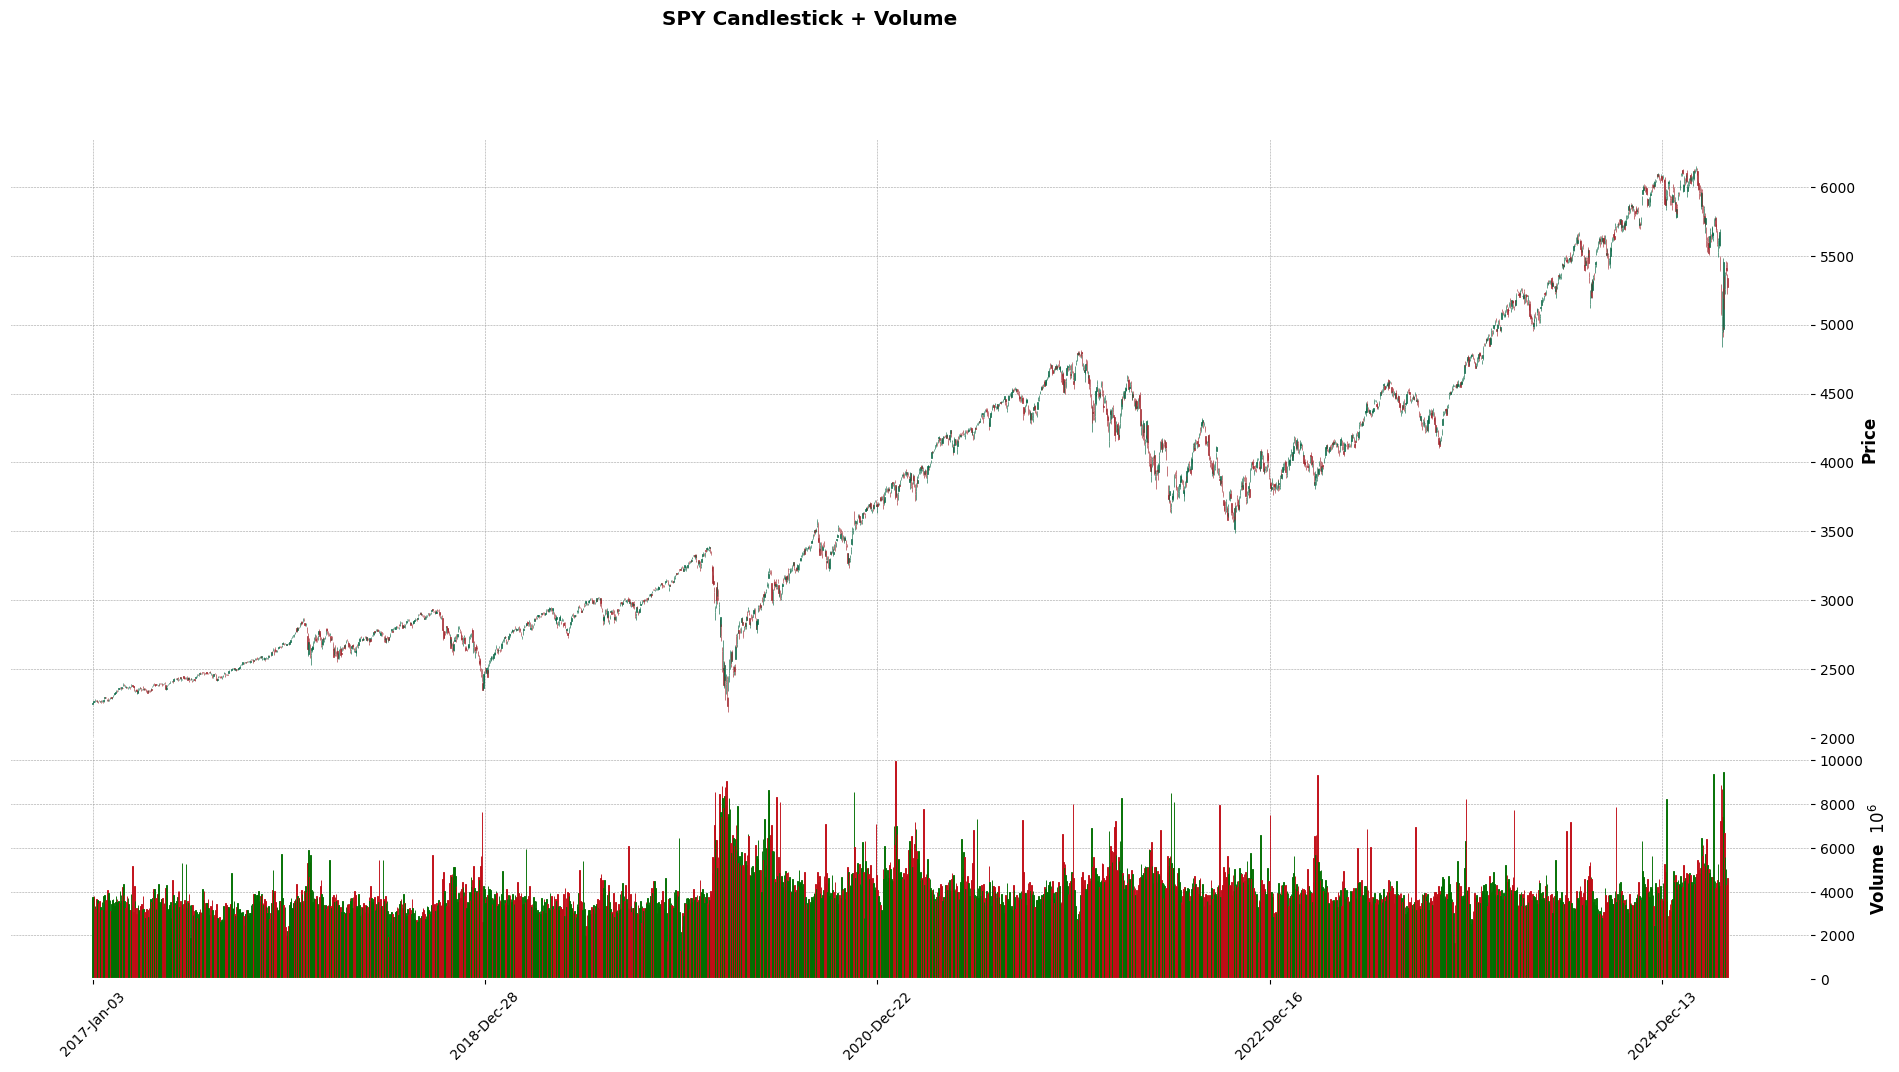

In [22]:
import mplfinance as mpf

mpf.plot(
  df_mpf,
  type='candle',
  volume=True,
  style='charles',
  title='SPY Candlestick + Volume',
  figsize=(25, 12) 
)


In [26]:
return_data.head(20)

QQQ_Close      ^RUT       ^VIX    EMA_20    ^GDAXI      MSFT   stdev_5  \
0   -0.043024 -0.296631   1.993072 -0.006206 -0.725528  0.350635  0.316581   
1    0.864767  1.585499  -5.947330  0.056868  0.426048  0.889458  0.424201   
2    0.988757  0.966249  -2.348684  0.128274  1.820703  0.251904  0.528980   
3   -0.020502 -0.494775  -1.665128  0.108820  0.360663  0.926479  0.459317   
4    0.099017 -0.356210  -0.470369  0.090012 -0.289994  2.349481  0.486897   
5   -0.831508 -1.340191  12.287336  0.023644 -1.120508 -0.988134  0.581326   
6    0.019240  0.701751   0.925923  0.012892 -1.254763 -0.736991  0.506387   
7    0.496187 -0.043322  -1.501246  0.014508  1.076611 -1.655074  0.249146   
8   -0.114303 -0.279154   1.016087  0.018564 -0.270593 -0.644847  0.267195   
9    0.542384  1.503570  -8.046941  0.086103  0.202444  0.807349  0.473796   
10  -0.056826 -0.811410   3.646305  0.057524 -1.215728 -0.062814  0.364685   
11   0.188405 -0.409756  -0.703605  0.054188  0.344059 -0.330003  0.353261   
12   0.145042 -0.170460   1.417182  0.055638 -0.052475 -0.141883  0.351039   
13   0.575984  1.456499  -4.978163  0.105387  0.861797  1.136715  0.396620   
14   0.331568  0.747894  -0.275733  0.129551  0.207074 -0.093636  0.306665   
15   0.520220  0.254892   2.027643  0.167636  0.921061  1.124999  0.254485   
16   0.322866  0.306671  -2.981029  0.190189 -0.022253  0.373065  0.197725   
17   0.637608  0.541291  11.452519  0.220152  0.187908 -0.061939  0.090223   
18  -0.078015 -0.361766  -1.754386  0.190346 -0.311088 -0.015527  0.247594   
19   0.407233  0.052174  -2.295922  0.188166 -0.001877  0.155026  0.258383   

       ^FTSE      GOOG      AAPL  ...  DX-Y.NYB     EUR=X  avgreturn10d  \
0  -0.655697  1.775112  0.066658  ... -0.575734 -0.504204     -0.051509   
1  -0.012591  0.556575 -0.091620  ...  0.189691 -0.437121      0.049623   
2   0.197196  1.432266  1.592078  ... -0.318884  0.299146      0.129884   
3  -0.040477 -0.421220  0.049234  ...  0.349894 -0.216713      0.094234   
4   0.321162 -1.062304  0.008170  ...  0.149434  0.646194      0.107017   
5  -0.918644 -2.549482 -0.262374  ... -0.099471 -0.289513      0.028423   
6  -0.271122 -0.689241 -0.230199  ... -0.916059  0.050360      0.049199   
7   0.119732 -0.137429  6.098040  ...  0.130637 -0.881320      0.034546   
8   0.465687  0.356295 -0.170875  ...  0.210758  0.338161      0.076342   
9   0.665192  0.370687  0.427937  ...  0.020034  0.052761      0.115327   
10 -0.223970 -0.018717  0.937401  ...  0.040053 -0.196944      0.121075   
11  0.195198  0.702557  0.951705  ...  0.350314  0.369856      0.057697   
12  0.036175  0.174737  0.387747  ...  0.019945  0.610217     -0.015631   
13  0.566161  0.145984  0.722607  ...  0.368970 -0.132410      0.049249   
14  0.405281  0.507658 -0.226577  ...  0.149033  0.315422      0.093574   
15  0.276907  0.684572  0.885589  ...  0.158726  0.367719      0.206128   
16 -0.141502  0.147689  1.297910  ...  0.287243  0.198589      0.255100   
17  0.465011 -0.179163  0.362897  ... -0.069136  0.190773      0.302039   
18 -0.335506  0.632492 -0.118038  ... -0.731368 -0.273978      0.287695   
19  0.303660  0.474427  0.273344  ...  0.507760 -0.607806      0.231833   

    2Y_Yield      EUR    SPY_RSI         DXY         JPY         ds  \
0  -3.333333  0.93338  54.669773  100.160004  113.809998 2017-01-23   
1   4.310345  0.92930  61.857468  100.349998  112.779999 2017-01-24   
2   1.652893  0.93208  63.926955  100.029999  113.839996 2017-01-25   
3  -1.626016  0.93006  63.965540  100.379997  113.292999 2017-01-26   
4   0.826446  0.93607  59.510150  100.529999  114.455002 2017-01-27   
5   0.000000  0.93336  56.071596  100.430000  114.667999 2017-01-30   
6  -2.459016  0.93383  54.943062   99.510002  113.650002 2017-01-31   
7   2.521008  0.92560  52.223722   99.639999  112.742996 2017-02-01   
8  -0.819672  0.92873  55.686728   99.849998  113.310997 2017-02-02   
9   0.000000  0.92922  60.962463   99.870003  112.789001 2017-02-03   
10 -4.13

### STD of each day 

In [23]:
# Compute daily std‐deviation of [Open, High, Low, Close]
SPY['daily_OHLC_std'] = SPY[['SPY_Open', 'SPY_High', 'SPY_Low', 'SPY_Close']].std(axis=1)

# Inspect the first few values
print(SPY[['SPY_Open', 'SPY_High', 'SPY_Low', 'SPY_Close', 'daily_OHLC_std']].head())


               SPY_Open     SPY_High      SPY_Low    SPY_Close  daily_OHLC_std
Date                                                                          
2017-01-03  2251.570068  2263.879883  2245.129883  2257.830078        8.070795
2017-01-04  2261.600098  2272.820068  2261.600098  2270.750000        5.940694
2017-01-05  2268.179932  2271.500000  2260.449951  2269.000000        4.768865
2017-01-06  2271.139893  2282.100098  2264.060059  2276.979980        7.761764
2017-01-09  2273.590088  2275.489990  2268.899902  2268.899902        3.347435


In [29]:
SPY['daily_OHLC_std'].max()

np.float64(296.00446517132895)

### Add VIX

In [ ]:
#aapl = yf.download("AAPL", start=start, end=end)
#print(data.tail())
VIX = yf.download("^VIX", start=start, end=end)[['Close', 'Volume','High','Low','Open']]
  

VIX.columns = ['VIX_Close', 'VIX_Volume', 'VIX_High', 'VIX_Low', 'VIX_Open']
print(VIX.tail())
#BIT = yf.download("GLD", start=start,end=end)

### Merge with VIX data

In [ ]:
SPY = SPY.join(VIX['VIX_Close'], how='left')

SPY.info()

We can see some correlation between valotility measures(VIX,daily_OHLC_std) and the vollum 

In [ ]:
# df is your DataFrame
corr_matrix = SPY.corr(method='pearson')  
# or method='spearman' / 'kendall'

print(corr_matrix)


                    SPY_Close  SPY_Volume  SPY_High   SPY_Low  SPY_Open  \
SPY_Close            1.000000    0.157775  0.999691  0.999703  0.999417   
SPY_Volume           0.157775    1.000000  0.167250  0.148945  0.159710   
SPY_High             0.999691    0.167250  1.000000  0.999501  0.999742   
SPY_Low              0.999703    0.148945  0.999501  1.000000  0.999674   
SPY_Open             0.999417    0.159710  0.999742  0.999674  1.000000   
daily_OHLC_std       0.314321    0.584564  0.329513  0.299841  0.316477   
Volume_in_Millions   0.157775    1.000000  0.167250  0.148945  0.159710   
VIX_Close            0.024942    0.650976  0.037536  0.015760  0.029235   

                    daily_OHLC_std  Volume_in_Millions  VIX_Close  
SPY_Close                 0.314321            0.157775   0.024942  
SPY_Volume                0.584564            1.000000   0.650976  
SPY_High                  0.329513            0.167250   0.037536  
SPY_Low                   0.299841            0.1489

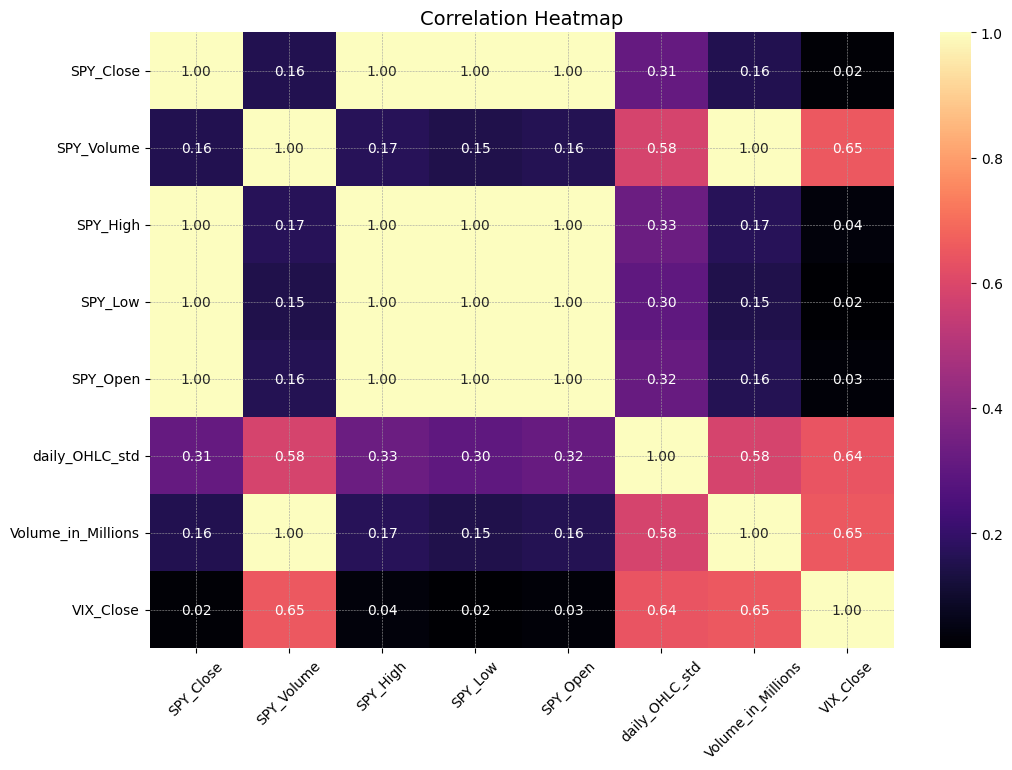

In [224]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))  # Adjust the figure size
sns.heatmap(corr_matrix, cmap='magma', annot=True, fmt=".2f")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)   # Keep y-axis labels horizontal
plt.title("Correlation Heatmap", fontsize=14)
plt.show()

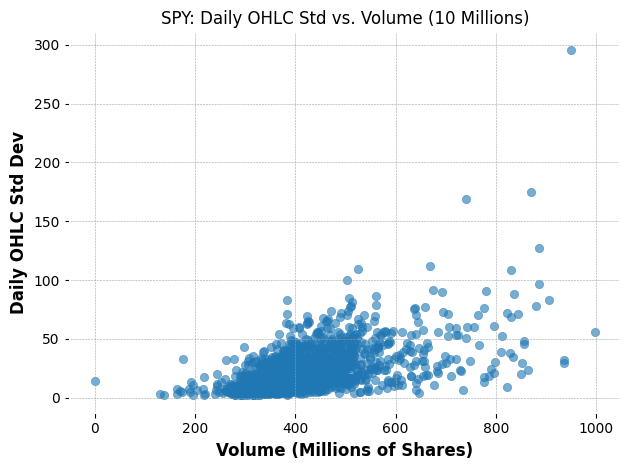

In [ ]:


# 1) Create a new column that expresses volume in millions of shares
SPY['Volume_in_Millions'] = SPY['SPY_Volume'] / 1e7

# 2) Plot using the rescaled column
sns.scatterplot(
    data=SPY,
    x='Volume_in_Millions',
    y='daily_OHLC_std',
    alpha=0.6,            # make points slightly transparent, if helpful
    edgecolor=None        # remove borders for large point sets
)
plt.xlabel('Volume (Millions of Shares)')
plt.ylabel('Daily OHLC Std Dev')
plt.title('SPY: Daily OHLC Std vs. Volume (10 Millions)')
plt.tight_layout()
plt.show()


In [105]:
spy = SPY.copy()
spy.reset_index(inplace=True)
spy.rename(columns={'Date': 'ds'}, inplace=True)
spy = spy[['ds','SPY_Close']]

In [111]:
spy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084 entries, 0 to 2083
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         2084 non-null   datetime64[ns]
 1   SPY_Close  2084 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 32.7 KB


# Merge some external data with S&P500 data 

In [116]:


data_lst = ['Actual_GDP', 'Actual_nonfarm', 'Actual_CPI', 'Actual_PPI','Actual_FOMC','ds']

def merge_data_with_spy(merge, spy, data_lst):
   
    merge = pd.merge(merge[data_lst], spy, on='ds', how='left')
    #merged_df.rename(columns={'SPY_Close': f'SPY_Close_{data}'}, inplace=True)
    return merge

merged = merge_data_with_spy(merged_df, spy, data_lst)



In [118]:

merged = merged.dropna()
merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 542 entries, 419 to 965
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Actual_GDP      542 non-null    object        
 1   Actual_nonfarm  542 non-null    object        
 2   Actual_CPI      542 non-null    object        
 3   Actual_PPI      542 non-null    object        
 4   Actual_FOMC     542 non-null    object        
 5   ds              542 non-null    datetime64[ns]
 6   SPY_Close       542 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 33.9+ KB


# Volatility on return data

In [32]:
stocks = pd.read_pickle('combined_cleaned_add_with_QQQ.pkl')
return_data = pd.read_pickle('df_with_QQQ.pkl')

In [205]:
#print(return_data.columns.to_list())
# Ensure 'ds' is in datetime format
return_data['abs_vol'].head(20)

0     3155240000
1     3816950000
2     3849340000
3     3611510000
4     3137420000
5     3595040000
6     4089730000
7     3919190000
8     3809760000
9     3605970000
10    3112390000
11    3452460000
12    3611950000
13    3681600000
14    3496600000
15    3352370000
16    3528040000
17    3785870000
18    3675900000
19    3516830000
Name: abs_vol, dtype: int64

Higher volatility does not necceserely means negative return, a big UP day can happend in an envirioment of high vol (mostly after a big sell-off in stocks)

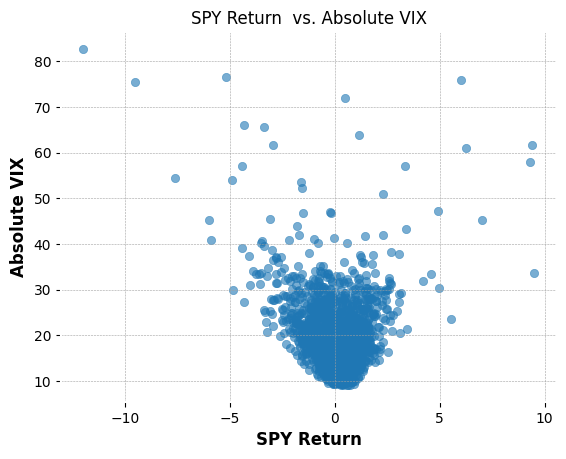

In [ ]:
sns.scatterplot(data=return_data,x='SPY_return',y='abs_vix', alpha=0.6, edgecolor=None)
plt.xlabel('SPY Return')
plt.ylabel('Absolute VIX')
plt.title('SPY Return vs. Absolute VIX')
plt.show()

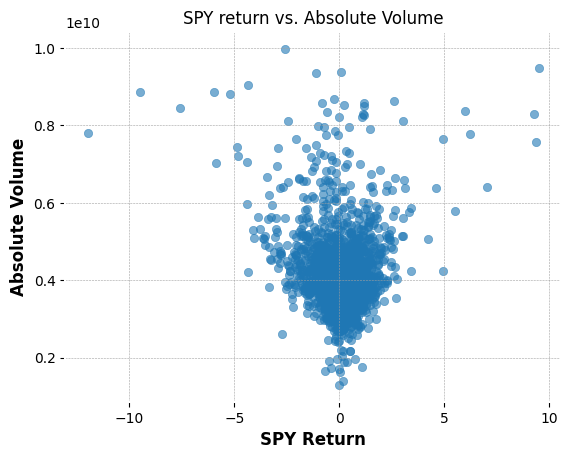

In [207]:
sns.scatterplot(data=return_data,x='SPY_return',y='abs_vol', alpha=0.6, edgecolor=None)
plt.xlabel('SPY Return')
plt.ylabel('Absolute Volume')
plt.title('SPY return vs. Absolute Volume')
plt.show()

# Daily return and economic data realeses:

In [120]:
spy_pct = return_data.copy()
spy_pct.reset_index(inplace=True)
spy_pct.rename(columns={'Date': 'ds'}, inplace=True)
spy_pct = spy_pct[['ds','SPY_return']]

In [185]:


data_lst = ['Actual_GDP', 'Actual_nonfarm', 'Actual_CPI', 'Actual_PPI','Actual_FOMC','ds','Actual_unemployment rate']

def merge_data_with_spy(merge, spy, data_lst):
   
    merge = pd.merge(merge[data_lst], spy, on='ds', how='left')
    #merged_df.rename(columns={'SPY_Close': f'SPY_Close_{data}'}, inplace=True)
    return merge

merged = merge_data_with_spy(merged_df, spy_pct, data_lst)



In [186]:

#merged = merged.dropna()
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Actual_GDP                204 non-null    float64       
 1   Actual_nonfarm            206 non-null    float64       
 2   Actual_CPI                155 non-null    float64       
 3   Actual_PPI                170 non-null    float64       
 4   Actual_FOMC               139 non-null    float64       
 5   ds                        973 non-null    datetime64[ns]
 6   Actual_unemployment rate  201 non-null    float64       
 7   SPY_return                539 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 60.9 KB


### Plot return vs actual data

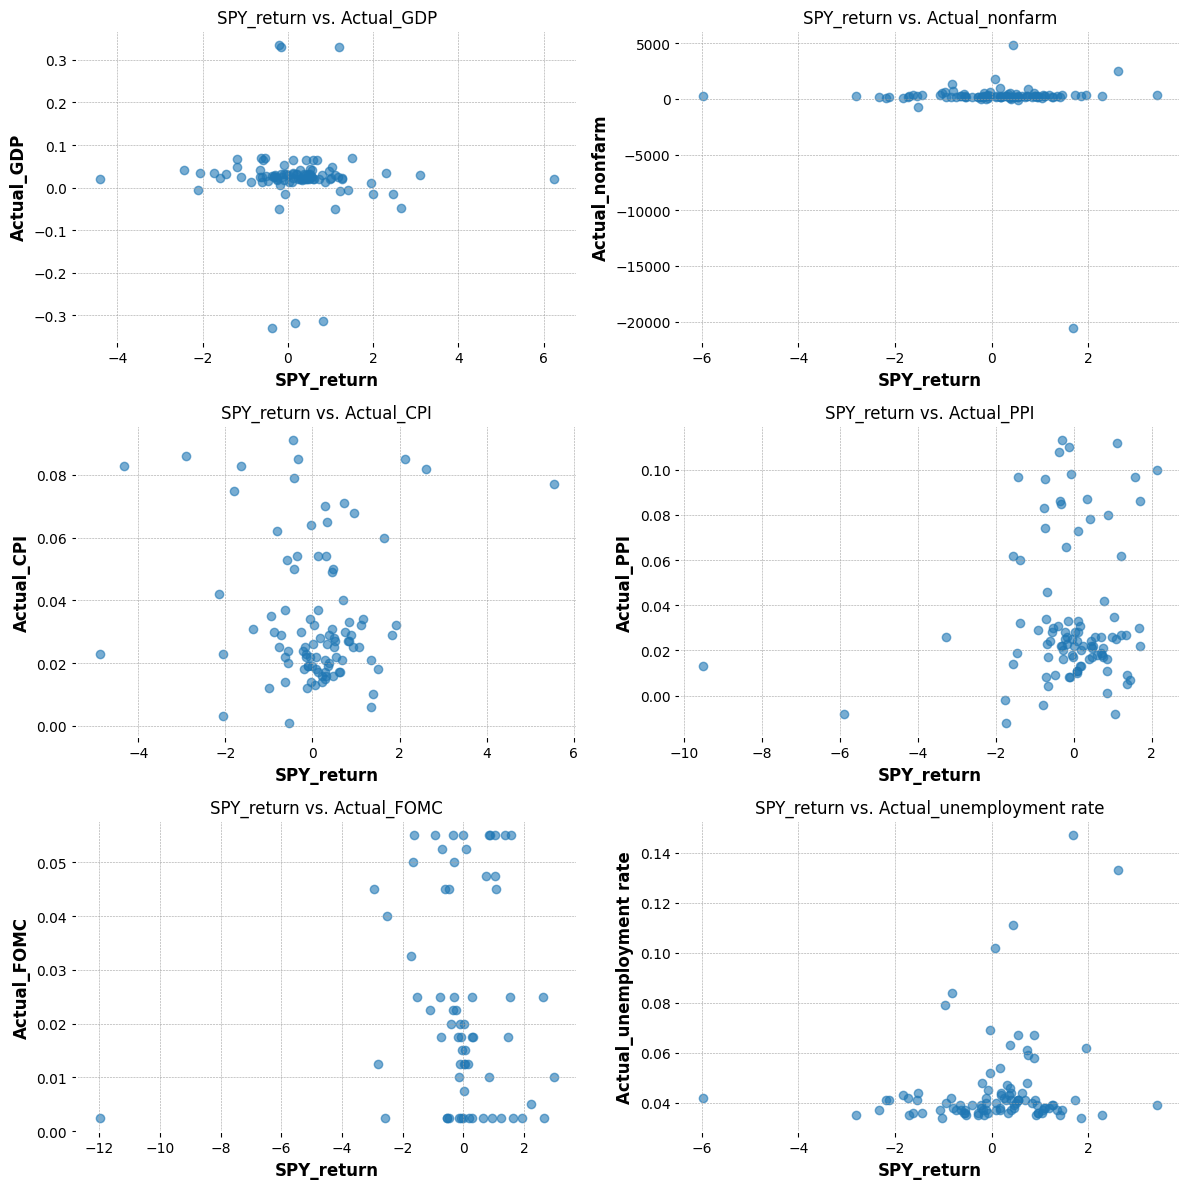

In [196]:
def plot_scatter_grid(df, target='SPY_return', exclude_cols=None, n_cols=2):
    """
    Plots a grid of scatterplots comparing the target column against each other numeric feature.

    Parameters:
    - df: pandas.DataFrame containing the data (must include `target` and other numeric features).
    - target: str, name of the column to plot on the x-axis.
    - exclude_cols: list of str, additional columns to exclude from features (beside `target`).
    - n_cols: int, number of columns in the subplot grid.
    """
    # Ensure target is always excluded
    if exclude_cols is None:
        exclude_cols = []
    exclude = set(exclude_cols) | {target}

    # Identify feature columns (excluding target and any others)
    features = [c for c in df.columns if c not in exclude]
    
    # Convert feature columns to numeric (coerce errors to NaN)
    for col in features:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Determine grid size
    n_features = len(features)
    n_rows = (n_features + n_cols - 1) // n_cols
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
    axes = axes.flatten()
    
    # Plot each scatter
    for ax, feat in zip(axes, features):
        ax.scatter(df[target], df[feat], alpha=0.6)
        ax.set_title(f'{target} vs. {feat}')
        ax.set_xlabel(target)
        ax.set_ylabel(feat)
    
    # Remove any unused axes
    for ax in axes[n_features:]:
        fig.delaxes(ax)
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_scatter_grid(merged, target='SPY_return', exclude_cols=['ds'], n_cols=2)

As it seems the CPI data is the most influencial on the price movments

In [189]:
print(merged_df.columns.to_list())

['ds', 'Actual_GDP', 'Actual_nonfarm', 'Actual_CPI', 'Actual_PPI', 'Actual_unemployment rate', 'Actual_core_PCE', 'Actual_FOMC', 'CPI_vs_forecast', 'CPI_vs_previous', 'GDP_vs_forecast', 'GDP_vs_previous', 'PPI_vs_forecast', 'PPI_vs_previous', 'nonfarm_vs_forecast', 'nonfarm_vs_previous', 'unemployment rate_vs_forecast', 'unemployment rate_vs_previous', 'core_PCE_vs_forecast', 'core_PCE_vs_previous', 'FOMC_vs_forecast', 'FOMC_vs_previous', 'event', 'holiday', 'shiler pe', 'Actual_20year', '20year_gap', '20year_sign', 'Actual_10year', '10year_gap', '10year_sign', 'Actual_2year', '2year_gap', '2year_sign']


### Plot returns on data days for bellow ,at and above estimate release

In [194]:
lst =['CPI_vs_forecast', 'GDP_vs_forecast', 'PPI_vs_forecast', 'nonfarm_vs_forecast','unemployment rate_vs_forecast', 'core_PCE_vs_forecast', 'FOMC_vs_forecast','ds']
merged_vs_forecast = merge_data_with_spy(merged_df, spy_pct, lst)
merged_vs_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   CPI_vs_forecast                155 non-null    float64       
 1   GDP_vs_forecast                204 non-null    float64       
 2   PPI_vs_forecast                155 non-null    float64       
 3   nonfarm_vs_forecast            206 non-null    float64       
 4   unemployment rate_vs_forecast  201 non-null    float64       
 5   core_PCE_vs_forecast           119 non-null    float64       
 6   FOMC_vs_forecast               135 non-null    float64       
 7   ds                             973 non-null    datetime64[ns]
 8   SPY_return                     539 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 68.5 KB


There is 3 diffrent values for each data columns [-1,0,1] when {-1 : the actual data was lower than expected , 0 : as expected , 1: higher than expected} I am ploting to see for each data column what is the mean SPY return 

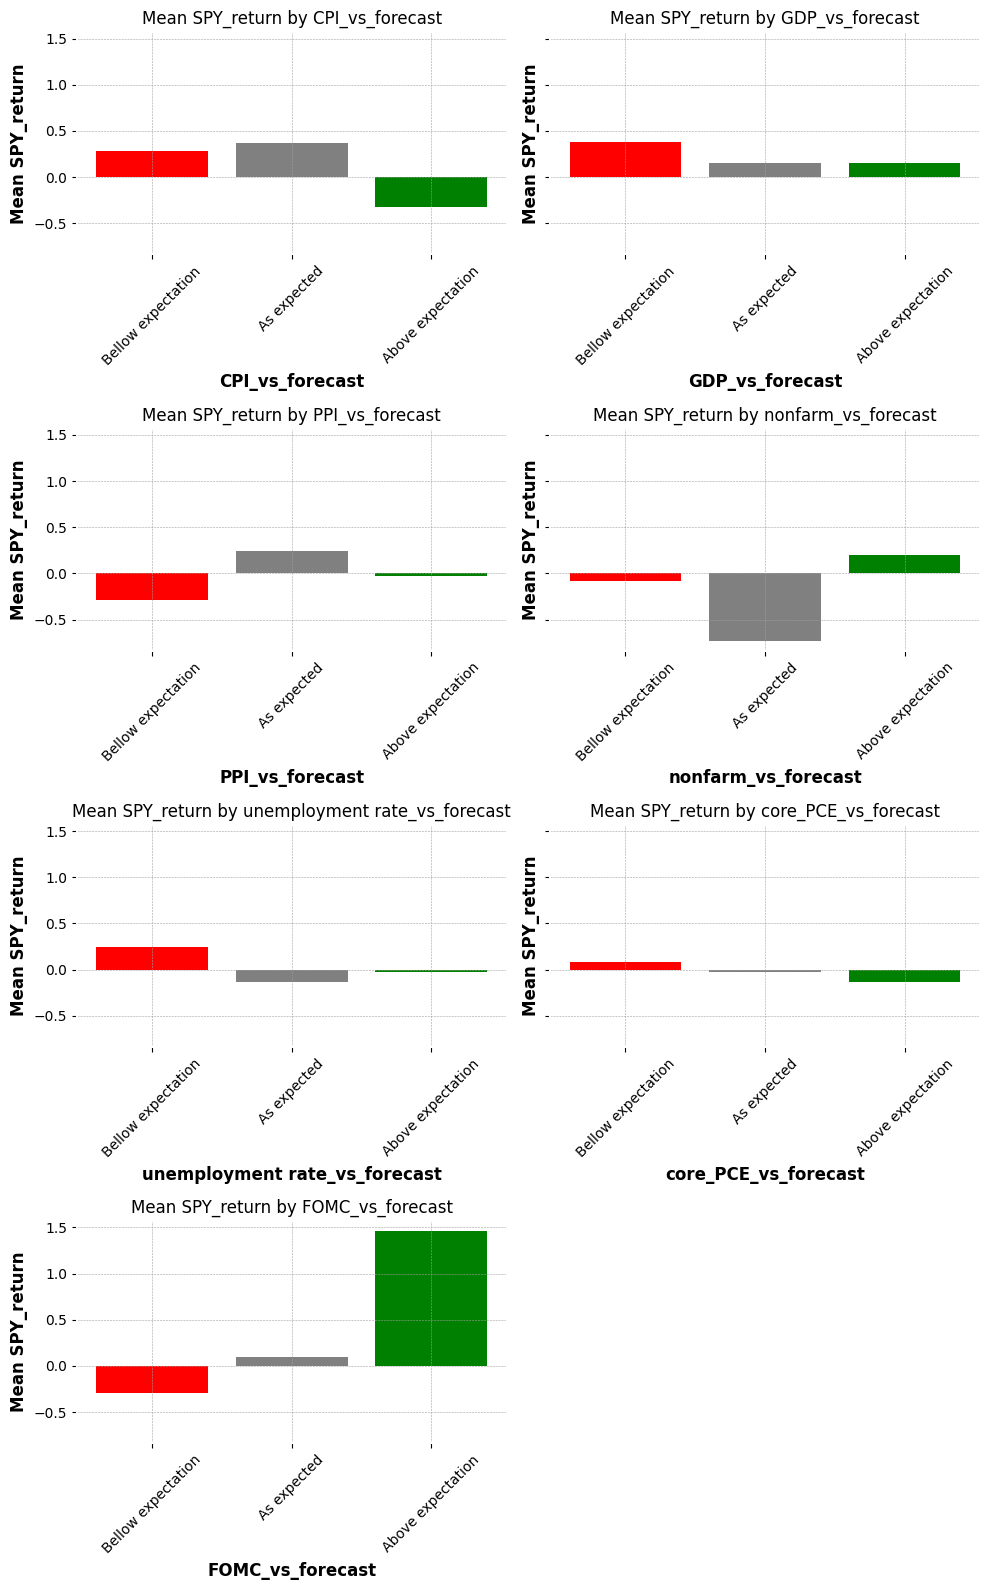

In [213]:
lst1 =['CPI_vs_forecast', 'GDP_vs_forecast', 'PPI_vs_forecast', 'nonfarm_vs_forecast','unemployment rate_vs_forecast', 'core_PCE_vs_forecast', 'FOMC_vs_forecast']

def plot_combined_mean_barplots(df, target, features, category_mapping, n_cols=2, subplot_size=(6, 4)):
    """
    Plots multiple barplots (one per feature) of mean(target) by categorical feature,
    all in one combined figure.

    Parameters:
    - df: pandas DataFrame containing data
    - target: str, name of the target column (e.g., 'SPY_return')
    - features: list of str, names of categorical features with values matching keys in category_mapping
    - category_mapping: dict mapping original category values to display labels
    - n_cols: int, number of subplot columns
    - subplot_size: tuple(width, height) in inches per subplot
    """
    # Determine grid layout
    n_features = len(features)
    n_rows = (n_features + n_cols - 1) // n_cols
    
    # Create figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(subplot_size[0] * n_cols, subplot_size[1] * n_rows), sharey=True)
    axes = axes.flatten()
    
    # For each feature, compute mean target by category and plot
    for idx, feat in enumerate(features):
        ax = axes[idx]
        
        # Compute mean by category, ensure all categories present
        mean_series = df.groupby(feat)[target].mean().reindex(category_mapping.keys())
        
        # Map index values to labels
        labels = [category_mapping[k] for k in mean_series.index]
        values = mean_series.values
        
        # Plot bar chart
        ax.bar(labels, values, color=['red', 'gray', 'green'])
        ax.set_title(f'Mean {target} by {feat}')
        ax.set_xlabel(feat)
        ax.set_ylabel(f'Mean {target}')
        ax.tick_params(axis='x', rotation=45)
    
    # Remove unused subplots
    for j in range(n_features, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Example usage:
category_labels = {-1: "Bellow expectation", 0: "As expected", 1: "Above expectation"}
# features = ['unemployment_rate_vs_forecast', 'Actual_GDP', ...]
plot_combined_mean_barplots(merged_vs_forecast, 'SPY_return', lst1, category_labels, n_cols=2, subplot_size=(5, 4))

In [208]:
return_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 47 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   QQQ_Close        2071 non-null   float64       
 1   ^RUT             2071 non-null   float64       
 2   ^VIX             2071 non-null   float64       
 3   EMA_20           2071 non-null   float64       
 4   ^GDAXI           2071 non-null   float64       
 5   MSFT             2071 non-null   float64       
 6   stdev_5          2071 non-null   float64       
 7   ^FTSE            2071 non-null   float64       
 8   GOOG             2071 non-null   float64       
 9   AAPL             2071 non-null   float64       
 10  high-low         2071 non-null   float64       
 11  avgreturn5d      2071 non-null   float64       
 12  abs_yield_curve  2071 non-null   float64       
 13  std_price        2071 non-null   float64       
 14  UNG              2071 non-null   float64

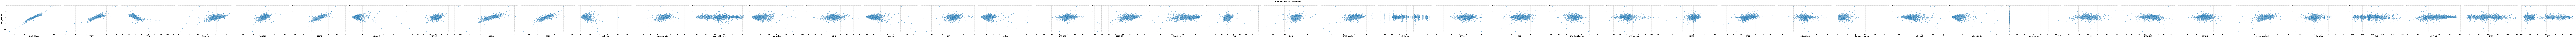

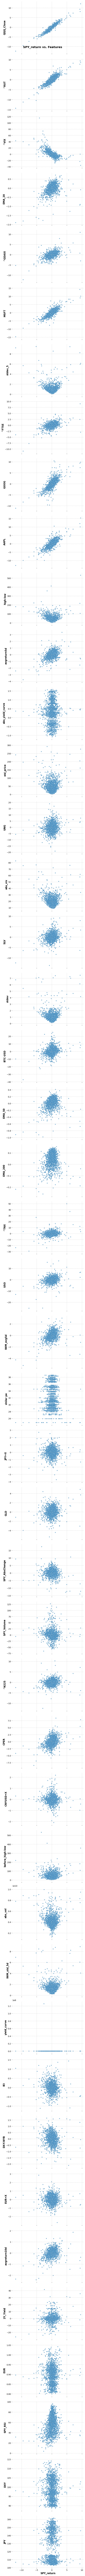

In [216]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_pairgrid_vs_target(
    df,
    target='SPY_return',
    exclude_cols=None,
    orientation='horizontal',
    height=4,
    aspect=1.2,
    margin_top=0.9
):
    """
    Uses Seaborn's PairGrid to create a row or column of scatter plots of target vs. each feature,
    excluding `target` and any additional columns (e.g. 'ds').

    Parameters:
    - df: pandas.DataFrame
    - target:    str, name of the column to appear on one axis (x if horizontal, y if vertical)
    - exclude_cols: list of str, additional columns to drop from plotting
    - orientation: 'horizontal' (one row) or 'vertical' (one column)
    - height:    float, height of each subplot in inches
    - aspect:    float, aspect ratio = width/height of each subplot
    - margin_top: float, fraction of figure height reserved above subplots for title
    """
    if exclude_cols is None:
        exclude_cols = []
    # Always exclude ds + target
    to_exclude = set(exclude_cols) | {target}
    features = [c for c in df.columns if c not in to_exclude]

    # Determine grid dims
    n = len(features)
    if orientation == 'horizontal':
        x_vars = features
        y_vars = [target]
        n_rows, n_cols = 1, n
        fig_w = height * aspect * n_cols
        fig_h = height * n_rows
    else:  # vertical
        x_vars = [target]
        y_vars = features
        n_rows, n_cols = n, 1
        fig_w = height * aspect * n_cols
        fig_h = height * n_rows

    # Build the PairGrid
    grid = sns.PairGrid(
        df,
        x_vars=x_vars,
        y_vars=y_vars,
        height=height,
        aspect=aspect
    )
    grid.map(sns.scatterplot, s=20, alpha=0.6)

    # Resize the figure to fit all subplots
    grid.fig.set_size_inches(fig_w, fig_h)
    grid.fig.subplots_adjust(top=margin_top)

    # Title
    direction = ' vs. '.join(
        ([target] if orientation=='horizontal' else [''] ) +
        features if orientation=='horizontal' else ([target] + features)
    )
    grid.fig.suptitle(f'{target} vs. Features', y=0.98)

    plt.tight_layout()
    plt.show()

# Example Usage:
# For a wide row of plots:
plot_pairgrid_vs_target(
    return_data,
    target='SPY_return',
    exclude_cols=['ds'],
    orientation='horizontal',
    height=4,
    aspect=1.5
)

# Or, for a tall column of plots (often easier to scroll vertically):
plot_pairgrid_vs_target(
    return_data,
    target='SPY_return',
    exclude_cols=['ds'],
    orientation='vertical',
    height=4,
    aspect=1.5
)



In [ ]:
from autoviz.AutoViz_Class import AutoViz_Class
AV = AutoViz_Class()
AV.AutoViz(tv_)